# Chapter 3: Generating Images from Text Using DALL-E 2

The code in this notebook is derived from the Github repo: https://github.com/lucidrains/DALLE2-pytorch/tree/main

## Downloading and Preparing Data

To download the dataset, visit the link https://cocodataset.org/#download and download the training and validation images for 2014 version along with their annotation files. The annotation files contain the mapping of image IDs to their captions. We will be training our model on the training data while monitoring the validation loss and once the model is trained, we can use it for zero-shot inferences from any data, hence we would not need test images. The MS-COCO dataset released in 2014 contains 164K images split into training (83K), validation (41K) and test (41K) sets. When you would download the dataset, it would download zip files for all the images, which are of different sizes, as well as the annotation files. Unzip the dataset into data/ directory. To load the (image, caption) pairs, we will create PyTorch's data loaders using datasets library.

In [1]:
! pip3 install -U torch==2.3.1
! pip3 install torchvision==0.17.2
! pip3 install pycocotools
! pip3 install transformers
! pip install timm
! pip install "numpy<2.0"

  Using cached torch-2.3.1-cp310-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.3.1-cp310-none-macosx_11_0_arm64.whl (61.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.2 requires torch==2.2.2, but you have torch 2.3.1 which is incompatible.
  Using cached torch-2.2.2-cp310-none-macosx_11_0_arm64.whl.metadata (25 kB)
Using cached torch-2.2.2-cp310-none-macosx_11_0_arm64.whl (59.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1


In [2]:
import torch
from torchvision import datasets, transforms
import bisect

/Users/rajatgoel/Documents/Manning Book Multimodal AI/Book Git Repo/book-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") # For Mac M1+

In [4]:
# Define data transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Path to data
train_dir = '../../Personal Git Repo/data/train2014'
val_dir = '../../Personal Git Repo/data/val2014'
train_ann_file = '../../Personal Git Repo/data/annotations/captions_train2014.json'
val_ann_file = '../../Personal Git Repo/data/annotations/captions_val2014.json'

In [6]:
# Images are <class 'PIL.Image.Image'> before transformation
train_data = datasets.CocoCaptions(root=train_dir, annFile=train_ann_file, transform=image_transform)
val_data = datasets.CocoCaptions(root=val_dir, annFile=val_ann_file, transform=image_transform)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [7]:
print('Number of samples: ', len(train_data))
img, target = train_data[3] # load 4th sample

print("Image Size: ", img.size())
print("Image ", type(img))
print(target)

Number of samples:  82783
Image Size:  torch.Size([3, 256, 256])
Image  <class 'torch.Tensor'>
['A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.']


In [8]:
class CocoCaptionsFlattened(torch.utils.data.Dataset):
    def __init__(self, coco_captions, device):
        self.coco_captions = coco_captions
        self.device = device
        
        print("Number of images:", len(self.coco_captions))
        caption_counts = [len(captions) for _, captions in coco_captions]
        self.cumulative_counts = self._compute_cumulative_counts(caption_counts)
        print("Number of image x caption pairs:", self.cumulative_counts[-1])

    def _compute_cumulative_counts(self, counts):
        cumulative = [0]
        for count in counts:
            cumulative.append(cumulative[-1] + count)
        return cumulative

    def __len__(self):
        return self.cumulative_counts[-1]

    def __getitem__(self, index):
        # Find the image index corresponding to the flattened caption index
        image_idx = bisect.bisect_right(self.cumulative_counts, index) - 1
        caption_idx = index - self.cumulative_counts[image_idx]
        # print(index, image_idx, caption_idx)
        image, captions = self.coco_captions[image_idx]
        return image.to(self.device), captions[caption_idx]

In [9]:
train_data_flattened = CocoCaptionsFlattened(train_data, device)

Number of images: 82783
Number of image x caption pairs: 414113


In [10]:
val_data_flattened = CocoCaptionsFlattened(val_data, device)

Number of images: 40504
Number of image x caption pairs: 202654


In [11]:
img, caption = train_data_flattened[10] # load 11th sample

print("Image Size: ", img.size())
print(caption)

Image Size:  torch.Size([3, 256, 256])
A flower vase is sitting on a porch stand.


In [12]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data_flattened, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data_flattened, batch_size=batch_size, shuffle=True)

## Helpers

In [14]:
from contextlib import contextmanager

In [15]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

@contextmanager
def null_context(*args, **kwargs):
    yield

def exists(val):
    return val is not None

def maybe(fn):
    @wraps(fn)
    def inner(x, *args, **kwargs):
        if not exists(x):
            return x
        return fn(x, *args, **kwargs)
    return inner

def is_float_dtype(dtype):
    return any([dtype == float_dtype for float_dtype in (torch.float64, torch.float32, torch.float16, torch.bfloat16)])

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

def cast_tuple(val, length = None, validate = True):
    if isinstance(val, list):
        val = tuple(val)

    out = val if isinstance(val, tuple) else ((val,) * default(length, 1))

    if exists(length) and validate:
        assert len(out) == length

    return out

def zero_init_(m):
    nn.init.zeros_(m.weight)
    if exists(m.bias):
        nn.init.zeros_(m.bias)

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

def module_device(module):
    if isinstance(module, nn.Identity):
        return 'cpu' # It doesn't matter
    return next(module.parameters()).device

def is_list_str(x):
    if not isinstance(x, (list, tuple)):
        return False
    return all([type(el) == str for el in x])

In [16]:
# for controlling freezing of CLIP

def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad

def freeze_all_layers_(module):
    set_module_requires_grad_(module, False)

def unfreeze_all_layers_(module):
    set_module_requires_grad_(module, True)

def freeze_model_and_make_eval_(model):
    model.eval()
    freeze_all_layers_(model)

In [17]:
# image normalization functions
# ddpms expect images to be in the range of -1 to 1
# but CLIP may otherwise

def normalize_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_zero_to_one(normed_img):
    return (normed_img + 1) * 0.5

## Load CLIP model

In [18]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install resize-right

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/84/h1vtggnn11g_xs1m3kzfns4h0000gn/T/pip-req-build-sh12z3gm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/84/h1vtggnn11g_xs1m3kzfns4h0000gn/T/pip-req-build-sh12z3gm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
import clip

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from torch import nn, einsum
import torchvision.transforms as T
from resize_right import resize

In [21]:
def resize_image_to(
    image,
    target_image_size,
    clamp_range = None,
    nearest = False,
    **kwargs
):
    orig_image_size = image.shape[-1]

    if orig_image_size == target_image_size:
        return image

    if not nearest:
        scale_factors = target_image_size / orig_image_size
        out = resize(image, scale_factors = scale_factors, **kwargs)
    else:
        out = F.interpolate(image, target_image_size, mode = 'nearest')

    if exists(clamp_range):
        out = out.clamp(*clamp_range)

    return out

In [22]:
class BaseClipAdapter(nn.Module):
    def __init__(self, clip, **kwargs):
        super().__init__()
        self.clip = clip
        self.overrides = kwargs

    def validate_and_resize_image(self, image):
        image_size = image.shape[-1]
        assert image_size >= self.image_size, f'you are passing in an image of size {image_size} but CLIP requires the image size to be at least {self.image_size}'
        return resize_image_to(image, self.image_size)

    @property
    def dim_latent(self):
        raise NotImplementedError

    @property
    def image_size(self):
        raise NotImplementedError

    @property
    def image_channels(self):
        raise NotImplementedError

    @property
    def max_text_len(self):
        raise NotImplementedError

    def embed_text(self, text):
        raise NotImplementedError

    def embed_image(self, image):
        raise NotImplementedError

In [23]:
from collections import namedtuple
EmbeddedText = namedtuple('EmbedTextReturn', ['text_embed', 'text_encodings'])
EmbeddedImage = namedtuple('EmbedImageReturn', ['image_embed', 'image_encodings'])

def l2norm(t):
    return F.normalize(t, dim = -1)

class OpenAIClipAdapter(BaseClipAdapter):
    def __init__(
        self,
        name = 'ViT-B/32'
    ):
        import clip
        openai_clip, preprocess = clip.load(name)
        super().__init__(openai_clip)
        self.eos_id = 49407 # for handling 0 being also '!'

        text_attention_final = self.find_layer('ln_final')

        self.dim_latent_ = text_attention_final.weight.shape[0]
        self.handle = text_attention_final.register_forward_hook(self._hook)

        self.clip_normalize = preprocess.transforms[-1]
        self.cleared = False

    def find_layer(self,  layer):
        modules = dict([*self.clip.named_modules()])
        return modules.get(layer, None)

    def clear(self):
        if self.cleared:
            return

        self.handle()

    def _hook(self, _, inputs, outputs):
        self.text_encodings = outputs

    @property
    def dim_latent(self):
        return self.dim_latent_

    @property
    def image_size(self):
        return self.clip.visual.input_resolution

    @property
    def image_channels(self):
        return 3

    @property
    def max_text_len(self):
        return self.clip.context_length

    @torch.no_grad()
    def embed_text(self, text):
        text = text[..., :self.max_text_len]

        is_eos_id = (text == self.eos_id)
        text_mask_excluding_eos = is_eos_id.cumsum(dim = -1) == 0
        text_mask = F.pad(text_mask_excluding_eos, (1, -1), value = True)
        text_mask = text_mask & (text != 0)
        assert not self.cleared

        text_embed = self.clip.encode_text(text)
        text_encodings = self.text_encodings
        text_encodings = text_encodings.masked_fill(~text_mask[..., None], 0.)
        del self.text_encodings
        return EmbeddedText(l2norm(text_embed.float()), text_encodings.float())

    @torch.no_grad()
    def embed_image(self, image):
        assert not self.cleared
        image = self.validate_and_resize_image(image)
        image = self.clip_normalize(image)
        image_embed = self.clip.encode_image(image)
        return EmbeddedImage(l2norm(image_embed.float()), None)

In [24]:
pretrained_clip = OpenAIClipAdapter().to(device)

In [25]:
train_data_iter = iter(train_loader)
first_batch = next(train_data_iter)
texts = list(first_batch[1])
images = first_batch[0]

In [26]:
# Test CLIP embedding generation
tokenized_texts = clip.tokenize(texts).to(device)
clip_text_embeddings = pretrained_clip.embed_text(tokenized_texts)
clip_image_embeddings = pretrained_clip.embed_image(images)

In [27]:
print(clip_text_embeddings.text_embed.shape)
print(clip_text_embeddings.text_encodings.shape)
print(clip_image_embeddings.image_embed.shape)

torch.Size([32, 512])
torch.Size([32, 77, 512])
torch.Size([32, 512])


## Diffusion Process

In [28]:
def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [29]:
class NoiseScheduler(nn.Module):
    def __init__(self, *, timesteps):
        super().__init__()

        betas = cosine_beta_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis = 0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        loss_fn = F.mse_loss
        self.loss_fn = loss_fn

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32)) # register buffer helper function to cast double back to float

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod)) # calculations for diffusion q(x_t | x_{t-1}) and others
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # calculations for posterior q(x_{t-1} | x_t, x_0)
        register_buffer('posterior_variance', posterior_variance)

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20))) # log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))


    def sample_random_times(self, batch):
        return torch.randint(0, self.num_timesteps, (batch,), device = self.betas.device, dtype = torch.long)

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def q_sample_from_to(self, x_from, from_t, to_t, noise = None):
        shape = x_from.shape
        noise = default(noise, lambda: torch.randn_like(x_from))

        alpha = extract(self.sqrt_alphas_cumprod, from_t, shape)
        sigma = extract(self.sqrt_one_minus_alphas_cumprod, from_t, shape)
        alpha_next = extract(self.sqrt_alphas_cumprod, to_t, shape)
        sigma_next = extract(self.sqrt_one_minus_alphas_cumprod, to_t, shape)

        return x_from * (alpha_next / alpha) + noise * (sigma_next * alpha - sigma * alpha_next) / alpha

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

In [30]:
# Test noise scheduler - forward diffusion
noise = torch.randn_like(img)
noise_scheduler = NoiseScheduler(timesteps=100).to(device)

In [31]:
from PIL import Image
from torchvision import transforms
from IPython.display import display, clear_output

def torch_tensor_to_image(tensor):
    # 1. Unnormalize the tensor
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    tensor = tensor * std + mean

    # 2. Clip the tensor values to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    
    # Convert the tensor to a PIL Image
    to_pil = transforms.ToPILImage()
    image_pil = to_pil(tensor)
    return image_pil

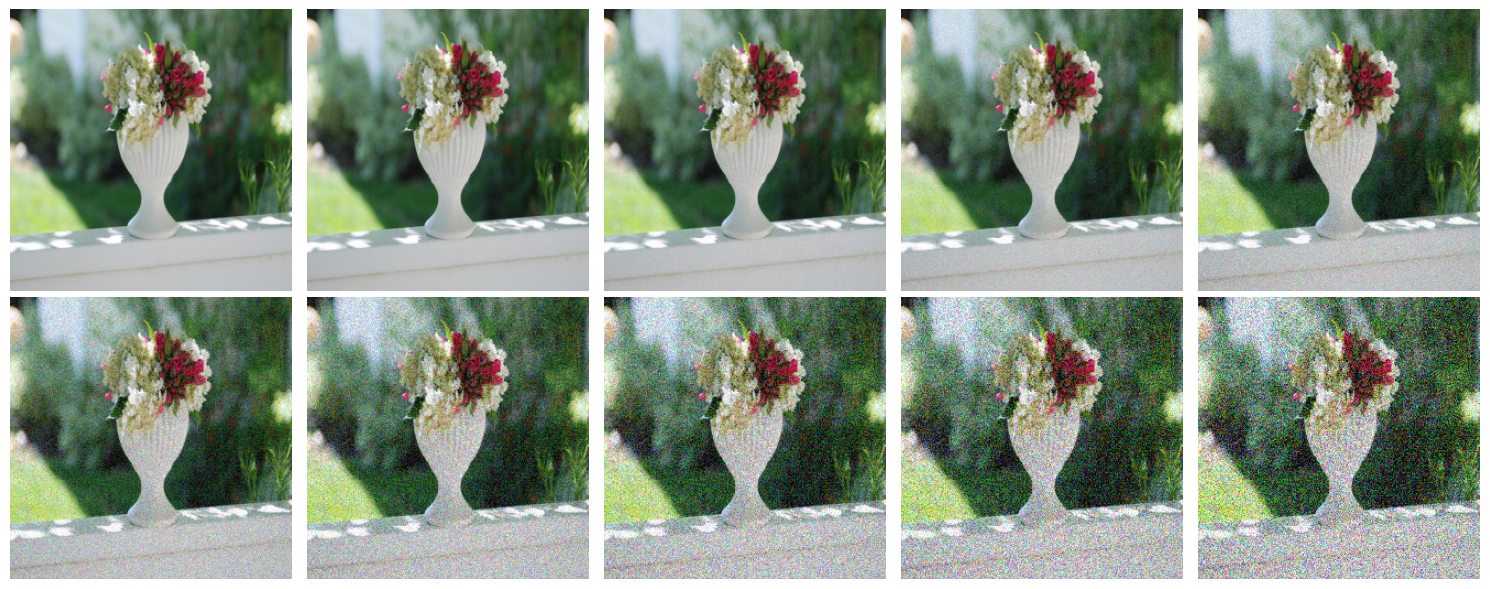

In [32]:
import matplotlib.pyplot as plt
import numpy as np

img_copy = img.clone().detach()
plt.figure(figsize=(15, 6))  # Adjust figure size as needed
for t in range(10):
    pil_img = torch_tensor_to_image(img_copy)
    plt.subplot(2, 5, t + 1)
    plt.imshow(np.array(pil_img))
    plt.axis('off')
    
    img_copy = noise_scheduler.q_sample(img_copy, torch.tensor([t]).to(device), noise)

plt.tight_layout()
display(plt.gcf())  # Display the current figure
clear_output(wait=True) # Clear previous output, wait to prevent flickering.
plt.close() # Close the figure to prevent memory issues.

## Diffusion Prior Model

### Causal Transformer

Install Rotary Embeddings library from https://github.com/lucidrains/rotary-embedding-torch

In [33]:
! pip install rotary-embedding-torch

In [34]:
import math
from einops import rearrange, repeat, reduce, pack, unpack

In [35]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5, fp16_eps = 1e-3, stable = False):
        super().__init__()
        self.eps = eps
        self.fp16_eps = fp16_eps
        self.stable = stable
        self.g = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        eps = self.eps if x.dtype == torch.float32 else self.fp16_eps

        if self.stable:
            x = x / x.amax(dim = -1, keepdim = True).detach()

        var = torch.var(x, dim = -1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = -1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

In [36]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [37]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        dtype, device = x.dtype, x.device
        assert is_float_dtype(dtype), 'input to sinusoidal pos emb must be a float type'

        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = device, dtype = dtype) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        return torch.cat((emb.sin(), emb.cos()), dim = -1).type(dtype)

In [38]:
class MLP(nn.Module):
    def __init__(
        self,
        dim_in,
        dim_out,
        *,
        expansion_factor = 2.,
        depth = 2,
        norm = False,
    ):
        super().__init__()
        hidden_dim = int(expansion_factor * dim_out)
        norm_fn = lambda: nn.LayerNorm(hidden_dim) if norm else nn.Identity()

        layers = [nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.SiLU(),
            norm_fn()
        )]

        for _ in range(depth - 1):
            layers.append(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                norm_fn()
            ))

        layers.append(nn.Linear(hidden_dim, dim_out))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x.float())

In [39]:
# relative positional bias for causal transformer

class RelPosBias(nn.Module):
    def __init__(
        self,
        heads = 8,
        num_buckets = 32,
        max_distance = 128,
    ):
        super().__init__()
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, heads)

    @staticmethod
    def _relative_position_bucket(
        relative_position,
        num_buckets = 32,
        max_distance = 128
    ):
        n = -relative_position
        n = torch.max(n, torch.zeros_like(n))

        max_exact = num_buckets // 2
        is_small = n < max_exact

        val_if_large = max_exact + (torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)).long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))
        return torch.where(is_small, n, val_if_large)

    def forward(self, i, j, *, device):
        q_pos = torch.arange(i, dtype = torch.long, device = device)
        k_pos = torch.arange(j, dtype = torch.long, device = device)
        rel_pos = rearrange(k_pos, 'j -> 1 j') - rearrange(q_pos, 'i -> i 1')
        rp_bucket = self._relative_position_bucket(rel_pos, num_buckets = self.num_buckets, max_distance = self.max_distance)
        values = self.relative_attention_bias(rp_bucket)
        return rearrange(values, 'i j h -> h i j')

In [40]:
class SwiGLU(nn.Module):
    """ used successfully in https://arxiv.org/abs/2204.0231 """
    def forward(self, x):
        x, gate = x.chunk(2, dim = -1)
        return x * F.silu(gate)

def FeedForward(
    dim,
    mult = 4,
    dropout = 0.,
    post_activation_norm = False
):
    """ post-activation norm https://arxiv.org/abs/2110.09456 """

    inner_dim = int(mult * dim)
    return nn.Sequential(
        LayerNorm(dim),
        nn.Linear(dim, inner_dim * 2, bias = False),
        SwiGLU(),
        LayerNorm(inner_dim) if post_activation_norm else nn.Identity(),
        nn.Dropout(dropout),
        nn.Linear(inner_dim, dim, bias = False)
    )

In [41]:
# attention

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        dim_head = 64,
        heads = 8,
        dropout = 0.,
        causal = False,
        rotary_emb = None,
        cosine_sim = True,
        cosine_sim_scale = 16
    ):
        super().__init__()
        self.scale = cosine_sim_scale if cosine_sim else (dim_head ** -0.5)
        self.cosine_sim = cosine_sim

        self.heads = heads
        inner_dim = dim_head * heads

        self.causal = causal
        self.norm = LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, dim_head * 2, bias = False)

        self.rotary_emb = rotary_emb

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, mask = None, attn_bias = None):
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = -1))

        q = rearrange(q, 'b n (h d) -> b h n d', h = self.heads)
        q = q * self.scale

        # rotary embeddings

        if exists(self.rotary_emb):
            q, k = map(self.rotary_emb.rotate_queries_or_keys, (q, k))

        # add null key / value for classifier free guidance in prior net

        nk, nv = map(lambda t: repeat(t, 'd -> b 1 d', b = b), self.null_kv.unbind(dim = -2))
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # whether to use cosine sim

        if self.cosine_sim:
            q, k = map(l2norm, (q, k))

        q, k = map(lambda t: t * math.sqrt(self.scale), (q, k))

        # calculate query / key similarities

        sim = einsum('b h i d, b j d -> b h i j', q, k)

        # relative positional encoding (T5 style)

        if exists(attn_bias):
            sim = sim + attn_bias

        # masking

        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        if self.causal:
            i, j = sim.shape[-2:]
            causal_mask = torch.ones((i, j), dtype = torch.bool, device = device).triu(j - i + 1)
            sim = sim.masked_fill(causal_mask, max_neg_value)

        # attention

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.type(sim.dtype)

        attn = self.dropout(attn)

        # aggregate values

        out = einsum('b h i j, b j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [42]:
from rotary_embedding_torch import RotaryEmbedding

class CausalTransformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        depth,
        dim_head = 64,
        heads = 8,
        ff_mult = 4,
        attn_dropout = 0.,
        ff_dropout = 0.,
        normformer = False,
        rotary_emb = True
    ):
        super().__init__()
        self.rel_pos_bias = RelPosBias(heads = heads)

        rotary_emb = RotaryEmbedding(dim = min(32, dim_head)) if rotary_emb else None

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim = dim, causal = True, dim_head = dim_head, heads = heads, dropout = attn_dropout, rotary_emb = rotary_emb),
                FeedForward(dim = dim, mult = ff_mult, dropout = ff_dropout, post_activation_norm = normformer)
            ]))

        self.norm = LayerNorm(dim, stable = True)
        self.project_out = nn.Linear(dim, dim, bias = False)

    def forward(self, x):
        n, device = x.shape[1], x.device
        attn_bias = self.rel_pos_bias(n, n + 1, device = device)

        for attn, ff in self.layers:
            x = attn(x, attn_bias = attn_bias) + x
            x = ff(x) + x

        out = self.norm(x)
        return self.project_out(out)

### Diffusion Prior Network

In [43]:
from einops.layers.torch import Rearrange

class DiffusionPriorNetwork(nn.Module):
    def __init__(
        self,
        dim,
        num_time_embeds = 1,
        num_image_embeds = 1,
        num_text_embeds = 1,
        max_text_len = 256,
        self_cond = False,
        **kwargs
    ):
        super().__init__()
        self.dim = dim

        self.num_time_embeds = num_time_embeds
        self.num_image_embeds = num_image_embeds
        self.num_text_embeds = num_text_embeds

        self.to_text_embeds = nn.Sequential(
            nn.Linear(dim, dim * num_text_embeds) if num_text_embeds > 1 else nn.Identity(),
            Rearrange('b (n d) -> b n d', n = num_text_embeds)
        )

        self.to_time_embeds = nn.Sequential(
            nn.Sequential(SinusoidalPosEmb(dim), MLP(dim, dim * num_time_embeds)),
            Rearrange('b (n d) -> b n d', n = num_time_embeds)
        )

        self.to_image_embeds = nn.Sequential(
            nn.Linear(dim, dim * num_image_embeds) if num_image_embeds > 1 else nn.Identity(),
            Rearrange('b (n d) -> b n d', n = num_image_embeds)
        )

        self.learned_query = nn.Parameter(torch.randn(dim))
        self.causal_transformer = CausalTransformer(dim = dim, **kwargs)

        self.max_text_len = max_text_len

        self.null_text_encodings = nn.Parameter(torch.randn(1, max_text_len, dim))
        self.null_text_embeds = nn.Parameter(torch.randn(1, num_text_embeds, dim))
        self.null_image_embed = nn.Parameter(torch.randn(1, dim))

    def forward(
        self,
        image_embed,
        diffusion_timesteps,
        *,
        text_embed,
        text_encodings = None,
        text_cond_drop_prob = 0.,
        image_cond_drop_prob = 0.
    ):
        batch, dim, device, dtype = *image_embed.shape, image_embed.device, image_embed.dtype
        num_time_embeds, num_image_embeds, num_text_embeds = self.num_time_embeds, self.num_image_embeds, self.num_text_embeds
    
        text_embed = self.to_text_embeds(text_embed)
        image_embed = self.to_image_embeds(image_embed)
        diffusion_timesteps = diffusion_timesteps.type(dtype)
        time_embed = self.to_time_embeds(diffusion_timesteps)
    
        learned_queries = repeat(self.learned_query, 'd -> b 1 d', b = batch)

        text_keep_mask = prob_mask_like((batch,), 1 - text_cond_drop_prob, device = device)
        text_keep_mask = rearrange(text_keep_mask, 'b -> b 1 1')
        
        image_keep_mask = prob_mask_like((batch,), 1 - image_cond_drop_prob, device = device)
        image_keep_mask = rearrange(image_keep_mask, 'b -> b 1 1')
        
        if not exists(text_encodings):
            text_encodings = torch.empty((batch, 0, dim), device = device, dtype = dtype)
        
        mask = torch.any(text_encodings != 0., dim = -1)
        
        # replace any padding in the text encodings with learned padding tokens unique across position
        text_encodings = text_encodings[:, :self.max_text_len]
        mask = mask[:, :self.max_text_len]
        
        text_len = text_encodings.shape[-2]
        remainder = self.max_text_len - text_len
        if remainder > 0:
            text_encodings = F.pad(text_encodings, (0, 0, 0, remainder), value = 0.)
            mask = F.pad(mask, (0, remainder), value = False)
        
        # mask out text encodings with null encodings
        null_text_encodings = self.null_text_encodings.to(text_encodings.dtype)
        text_encodings = torch.where(
            rearrange(mask, 'b n -> b n 1').clone() & text_keep_mask,
            text_encodings,
            null_text_encodings
        )
        
        # mask out text embeddings with null text embeddings
        null_text_embeds = self.null_text_embeds.to(text_embed.dtype)
        text_embed = torch.where(
            text_keep_mask,
            text_embed,
            null_text_embeds
        )
        
        # mask out image embeddings with null image embeddings
        null_image_embed = self.null_image_embed.to(image_embed.dtype)
        image_embed = torch.where(
            image_keep_mask,
            image_embed,
            null_image_embed
        )

        tokens = torch.cat((
            text_encodings,
            text_embed,
            time_embed,
            image_embed,
            learned_queries
        ), dim = -2)
        
        tokens = self.causal_transformer(tokens)
        
        # get learned query, which should predict the image embedding (per DDPM timestep)
        pred_image_embed = tokens[..., -1, :]
        return pred_image_embed

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        **kwargs
    ):
        logits = self.forward(*args, **kwargs)
    
        if cond_scale == 1:
            return logits
    
        null_logits = self.forward(*args, text_cond_drop_prob = 1., image_cond_drop_prob = 1, **kwargs)
        return null_logits + (logits - null_logits) * cond_scale

### Diffusion Prior

In [44]:
class DiffusionPrior(nn.Module):
    def __init__(
        self,
        net,
        clip,
        *,
        timesteps = 1000,
        sample_timesteps = None,
        cond_drop_prob = 0.,
        text_cond_drop_prob = None,
        image_cond_drop_prob = None,
        condition_on_text_encodings = True
    ):
        super().__init__()

        self.sample_timesteps = sample_timesteps

        self.noise_scheduler = NoiseScheduler(timesteps = timesteps)

        assert isinstance(clip, BaseClipAdapter)
        freeze_model_and_make_eval_(clip)
        self.clip = clip

        self.net = net # Diffusion Prior Network
        self.image_embed_dim = clip.dim_latent

        assert net.dim == self.image_embed_dim, f'your diffusion prior network has a dimension of {net.dim}, but you set your image embedding dimension (keyword image_embed_dim) on DiffusionPrior to {self.image_embed_dim}'
        assert clip.dim_latent == self.image_embed_dim, f'you passed in a CLIP to the diffusion prior with latent dimensions of {clip.dim_latent}, but your image embedding dimension (keyword image_embed_dim) for the DiffusionPrior was set to {self.image_embed_dim}'

        self.channels = clip.image_channels

        self.text_cond_drop_prob = default(text_cond_drop_prob, cond_drop_prob)
        self.image_cond_drop_prob = default(image_cond_drop_prob, cond_drop_prob)

        self.can_classifier_guidance = self.text_cond_drop_prob > 0. and self.image_cond_drop_prob > 0.
        self.condition_on_text_encodings = condition_on_text_encodings

        # device tracker
        self.register_buffer('_dummy', torch.tensor([True]), persistent = False)

    @property
    def device(self):
        return self._dummy.device

    def l2norm_clamp_embed(self, image_embed):
        return l2norm(image_embed) * self.image_embed_scale

    def p_mean_variance(self, x, t, text_cond, cond_scale = 1.):
        assert not (cond_scale != 1. and not self.can_classifier_guidance), 'The model was not trained with conditional dropout. Cannot use classifier free guidance'
        
        pred = self.net.forward_with_cond_scale(x, t, cond_scale = cond_scale, **text_cond)
        
        model_mean, posterior_variance, posterior_log_variance = self.noise_scheduler.q_posterior(x_start=pred, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance, pred

    @torch.no_grad()
    def p_sample(self, x, t, text_cond = None, cond_scale = 1.):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = t, text_cond = text_cond, cond_scale = cond_scale)
        noise = torch.randn_like(x)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        pred = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred

    @torch.no_grad()
    def p_sample_loop(self, batch_size, text_cond, cond_scale = 1.):
        shape = (batch_size, self.image_embed_dim)
        device = self.device
    
        image_embed = torch.randn(shape, device = device)
    
        for i in tqdm(reversed(range(0, self.noise_scheduler.num_timesteps)), desc='sampling loop time step', total=self.noise_scheduler.num_timesteps):
            times = torch.full((batch_size,), i, device = device, dtype = torch.long)
            image_embed = self.p_sample(image_embed, times, text_cond = text_cond, cond_scale = cond_scale)
    
        return image_embed

    @torch.no_grad()
    @eval_decorator
    def sample(
        self,
        text,
        num_samples_per_batch = 2,
        cond_scale = 1.,
        timesteps = 100
    ):
    
        # repeat text prompts num_samples_per_batch times to get multiple image embeddings for comparison
        text = repeat(text, 'b ... -> (b r) ...', r = num_samples_per_batch)
    
        batch_size = text.shape[0]
    
        text_embed, text_encodings = self.clip.embed_text(text)
        text_cond = dict(text_embed = text_embed)
    
        if self.condition_on_text_encodings:
            text_cond = {**text_cond, 'text_encodings': text_encodings}
    
        image_embeds = self.p_sample_loop(batch_size, text_cond = text_cond, cond_scale = cond_scale)
    
        # calculate similarity scores
        text_embeds = text_cond['text_embed']
    
        text_embeds = rearrange(text_embeds, '(b r) d -> b r d', r = num_samples_per_batch)
        image_embeds = rearrange(image_embeds, '(b r) d -> b r d', r = num_samples_per_batch)
    
        text_image_sims = einsum('b r d, b r d -> b r', l2norm(text_embeds), l2norm(image_embeds))
        top_sim_indices = text_image_sims.topk(k = 1).indices # get image with top similarity score
    
        top_sim_indices = repeat(top_sim_indices, 'b 1 -> b 1 d', d = self.image_embed_dim)
        top_image_embeds = image_embeds.gather(1, top_sim_indices)
        
        return rearrange(top_image_embeds, 'b 1 d -> b d')

    def p_losses(self, image_embed, times, text_cond, noise = None):
        noise = default(noise, lambda: torch.randn_like(image_embed))
        image_embed_noisy = self.noise_scheduler.q_sample(x_start = image_embed, t = times, noise = noise)
    
        pred = self.net(
            image_embed_noisy,
            times,
            text_cond_drop_prob = self.text_cond_drop_prob,
            image_cond_drop_prob = self.image_cond_drop_prob,
            **text_cond
        )
    
        target = image_embed
        loss = self.noise_scheduler.loss_fn(pred, target)
        return loss

    def forward(
        self,
        text = None,
        image = None,
        *args,
        **kwargs
    ):
    
        image_embed, _ = self.clip.embed_image(image)
        text_embed, text_encodings = self.clip.embed_text(text)
    
        text_cond = dict(text_embed = text_embed)
    
        if self.condition_on_text_encodings:
            text_cond = {**text_cond, 'text_encodings': text_encodings}
    
        batch, device = image_embed.shape[0], image_embed.device
        times = self.noise_scheduler.sample_random_times(batch)
    
        return self.p_losses(image_embed, times, text_cond = text_cond, *args, **kwargs)

### Training Diffusion Prior Model

In [45]:
prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).to(device)

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = pretrained_clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).to(device)

In [46]:
from tqdm import tqdm

In [49]:
def model_epoch(model, data_loader, max_batches=None, train=True):
    if not max_batches:
        max_batches = len(data_loader)

    acc_loss = 0
    num_samples = 0
    
    curr_batch = 0
    tqdm_object = tqdm(data_loader, total=max_batches)
    
    for batch in tqdm_object:
        curr_batch += 1
        if curr_batch > max_batches:
            break
    
        tokenized_texts = clip.tokenize(batch[1]).to(device)
        
        loss = model(text=tokenized_texts, image=batch[0])
        if train:
            loss.backward()
    
        count = len(batch[0]) # number of images in the batch
        num_samples += count
        acc_loss += loss.item() * count
        avg_loss = acc_loss / num_samples
        tqdm_object.set_postfix(loss=avg_loss)

    return avg_loss

In [51]:
num_epochs = 1
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    print("Training model...")
    diffusion_prior.train()
    train_loss = model_epoch(model=diffusion_prior, data_loader=train_loader, max_batches=2)

    print("Validating model...")
    diffusion_prior.eval()
    with torch.no_grad():
        val_loss = model_epoch(model=diffusion_prior, data_loader=val_loader, max_batches=2, train=False)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(diffusion_prior, "diffusion_prior.pt")

Epoch: 1
Training model...


100%|████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it, loss=0.328]


Validating model...


100%|████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s, loss=0.327]


## Diffusion Decoder

### U-Net

In [66]:
from functools import partial, wraps
from einops.layers.torch import Rearrange
from tqdm import tqdm

In [33]:
class RearrangeToSequence(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        x = rearrange(x, 'b c ... -> b ... c')
        x, ps = pack([x], 'b * c')

        x = self.fn(x)

        x, = unpack(x, ps, 'b * c')
        x = rearrange(x, 'b ... c -> b c ...')
        return x

In [34]:
def Downsample(dim, dim_out = None):
    # https://arxiv.org/abs/2208.03641 shows this is the most optimal way to downsample
    # named SP-conv in the paper, but basically a pixel unshuffle
    dim_out = default(dim_out, dim)
    return nn.Sequential(
        Rearrange('b c (h s1) (w s2) -> b (c s1 s2) h w', s1 = 2, s2 = 2),
        nn.Conv2d(dim * 4, dim_out, 1)
    )

In [35]:
class PixelShuffleUpsample(nn.Module):
    """
    code shared by @MalumaDev at DALLE2-pytorch for addressing checkboard artifacts
    https://arxiv.org/ftp/arxiv/papers/1707/1707.02937.pdf
    """
    def __init__(self, dim, dim_out = None):
        super().__init__()
        dim_out = default(dim_out, dim)
        conv = nn.Conv2d(dim, dim_out * 4, 1)

        self.net = nn.Sequential(
            conv,
            nn.SiLU(),
            nn.PixelShuffle(2)
        )

        self.init_conv_(conv)

    def init_conv_(self, conv):
        o, i, h, w = conv.weight.shape
        conv_weight = torch.empty(o // 4, i, h, w)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = repeat(conv_weight, 'o ... -> (o 4) ...')

        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

In [36]:
class CrossEmbedLayer(nn.Module):
    def __init__(
        self,
        dim_in,
        kernel_sizes,
        dim_out = None,
        stride = 2
    ):
        super().__init__()
        assert all([*map(lambda t: (t % 2) == (stride % 2), kernel_sizes)])
        dim_out = default(dim_out, dim_in)

        kernel_sizes = sorted(kernel_sizes)
        num_scales = len(kernel_sizes)

        # calculate the dimension at each scale
        dim_scales = [int(dim_out / (2 ** i)) for i in range(1, num_scales)]
        dim_scales = [*dim_scales, dim_out - sum(dim_scales)]

        self.convs = nn.ModuleList([])
        for kernel, dim_scale in zip(kernel_sizes, dim_scales):
            self.convs.append(nn.Conv2d(dim_in, dim_scale, kernel, stride = stride, padding = (kernel - stride) // 2))

    def forward(self, x):
        fmaps = tuple(map(lambda conv: conv(x), self.convs))
        return torch.cat(fmaps, dim = 1)

In [37]:
class CrossAttention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        context_dim = None,
        dim_head = 64,
        heads = 8,
        dropout = 0.,
        norm_context = False,
        cosine_sim = False,
        cosine_sim_scale = 16
    ):
        super().__init__()
        self.cosine_sim = cosine_sim
        self.scale = cosine_sim_scale if cosine_sim else (dim_head ** -0.5)
        self.heads = heads
        inner_dim = dim_head * heads

        context_dim = default(context_dim, dim)

        self.norm = LayerNorm(dim)
        self.norm_context = LayerNorm(context_dim) if norm_context else nn.Identity()
        self.dropout = nn.Dropout(dropout)

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, context, mask = None):
        b, n, device = *x.shape[:2], x.device

        x = self.norm(x)
        context = self.norm_context(context)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), (q, k, v))

        # add null key / value for classifier free guidance in prior net

        nk, nv = map(lambda t: repeat(t, 'd -> b h 1 d', h = self.heads,  b = b), self.null_kv.unbind(dim = -2))

        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        if self.cosine_sim:
            q, k = map(l2norm, (q, k))

        q, k = map(lambda t: t * math.sqrt(self.scale), (q, k))

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.type(sim.dtype)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [38]:
class Block(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        groups = 8,
        weight_standardization = False
    ):
        super().__init__()
        conv_klass = nn.Conv2d if not weight_standardization else WeightStandardizedConv2d

        self.project = conv_klass(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.project(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

In [39]:
class ResnetBlock(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        cond_dim = None,
        time_cond_dim = None,
        groups = 8,
        weight_standardization = False,
        cosine_sim_cross_attn = False
    ):
        super().__init__()

        self.time_mlp = None

        if exists(time_cond_dim):
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_cond_dim, dim_out * 2)
            )

        self.cross_attn = None

        if exists(cond_dim):
            self.cross_attn = CrossAttention(
                dim = dim_out,
                context_dim = cond_dim,
                cosine_sim = cosine_sim_cross_attn
            )

        self.block1 = Block(dim, dim_out, groups = groups, weight_standardization = weight_standardization)
        self.block2 = Block(dim_out, dim_out, groups = groups, weight_standardization = weight_standardization)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None, cond = None):

        scale_shift = None
        if exists(self.time_mlp) and exists(time_emb):
            time_emb = self.time_mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        if exists(self.cross_attn):
            assert exists(cond)

            h = rearrange(h, 'b c ... -> b ... c')
            h, ps = pack([h], 'b * c')

            h = self.cross_attn(h, context = cond) + h

            h, = unpack(h, ps, 'b * c')
            h = rearrange(h, 'b ... c -> b c ...')

        h = self.block2(h)
        return h + self.res_conv(x)

In [40]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        *,
        image_embed_dim = None,
        text_embed_dim = None,
        cond_dim = None,
        num_image_tokens = 4,
        num_time_tokens = 2,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        attn_dim_head = 32,
        attn_heads = 16,
        attend_at_middle = True,         # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        cond_on_text_encodings = False,
        max_text_len = 256,
        cond_on_image_embeds = False,
        add_image_embeds_to_time = True, # alerted by @mhh0318 to a phrase in the paper - "Specifically, we modify the architecture described in Nichol et al. (2021) by projecting and adding CLIP embeddings to the existing timestep embedding"
        init_conv_kernel_size = 7,
        resnet_groups = 8,
        resnet_weight_standardization = False,
        num_resnet_blocks = 2,
        init_cross_embed_kernel_sizes = (3, 7, 15),
        cross_embed_downsample = False,
        cross_embed_downsample_kernel_sizes = (2, 4),
        pixel_shuffle_upsample = True,
        final_conv_kernel_size = 1,
        combine_upsample_fmaps = False, # whether to combine the outputs of all upsample blocks, as in unet squared paper
        checkpoint_during_training = False,
        **kwargs
    ):
        super().__init__()
        # save locals to take care of some hyperparameters for cascading DDPM

        self._locals = locals()
        del self._locals['self']
        del self._locals['__class__']

        # determine dimensions

        self.channels = channels
        self.channels_out = channels

        init_channels = channels
        init_dim = dim

        self.init_conv = CrossEmbedLayer(init_channels, dim_out = init_dim, kernel_sizes = init_cross_embed_kernel_sizes, stride = 1)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        num_stages = len(in_out)

        # time, image embeddings, and optional text encoding

        cond_dim = default(cond_dim, dim)
        time_cond_dim = dim * 4

        self.to_time_hiddens = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, time_cond_dim),
            nn.GELU()
        )

        self.to_time_tokens = nn.Sequential(
            nn.Linear(time_cond_dim, cond_dim * num_time_tokens),
            Rearrange('b (r d) -> b r d', r = num_time_tokens)
        )

        self.to_time_cond = nn.Sequential(
            nn.Linear(time_cond_dim, time_cond_dim)
        )

        self.image_to_tokens = nn.Sequential(
            nn.Linear(image_embed_dim, cond_dim * num_image_tokens),
            Rearrange('b (n d) -> b n d', n = num_image_tokens)
        ) if cond_on_image_embeds and image_embed_dim != cond_dim else nn.Identity()

        self.to_image_hiddens = nn.Sequential(
            nn.Linear(image_embed_dim, time_cond_dim),
            nn.GELU()
        ) if cond_on_image_embeds and add_image_embeds_to_time else None

        self.norm_cond = nn.LayerNorm(cond_dim)
        self.norm_mid_cond = nn.LayerNorm(cond_dim)

        # text encoding conditioning (optional)
        self.text_to_cond = None
        self.text_embed_dim = None

        if cond_on_text_encodings:
            assert exists(text_embed_dim), 'text_embed_dim must be given to the unet if cond_on_text_encodings is True'
            self.text_to_cond = nn.Linear(text_embed_dim, cond_dim)
            self.text_embed_dim = text_embed_dim


        # finer control over whether to condition on image embeddings and text encodings
        # so one can have the latter unets in the cascading DDPMs only focus on super-resoluting
        self.cond_on_text_encodings = cond_on_text_encodings
        self.cond_on_image_embeds = cond_on_image_embeds

        # for classifier free guidance
        self.null_image_embed = nn.Parameter(torch.randn(1, num_image_tokens, cond_dim))
        self.null_image_hiddens = nn.Parameter(torch.randn(1, time_cond_dim))

        self.max_text_len = max_text_len
        self.null_text_embed = nn.Parameter(torch.randn(1, max_text_len, cond_dim))

        # attention related params
        attn_kwargs = dict(heads = attn_heads, dim_head = attn_dim_head)
        create_self_attn = lambda dim: RearrangeToSequence(Residual(Attention(dim, **attn_kwargs)))

        # resnet block klass
        resnet_groups = cast_tuple(resnet_groups, num_stages)
        top_level_resnet_group = resnet_groups[0]

        num_resnet_blocks = cast_tuple(num_resnet_blocks, num_stages)

        # downsample klass
        downsample_klass = Downsample
        if cross_embed_downsample:
            downsample_klass = partial(CrossEmbedLayer, kernel_sizes = cross_embed_downsample_kernel_sizes)

        # upsample klass
        upsample_klass = NearestUpsample if not pixel_shuffle_upsample else PixelShuffleUpsample

        # prepare resnet klass
        resnet_block = partial(ResnetBlock, weight_standardization = resnet_weight_standardization)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        skip_connect_dims = []          # keeping track of skip connection dimensions

        for ind, ((dim_in, dim_out), groups, layer_num_resnet_blocks) in enumerate(zip(in_out, resnet_groups, num_resnet_blocks)):
            is_first = ind == 0
            is_last = ind >= (num_resolutions - 1)
            layer_cond_dim = cond_dim if not is_first else None

            dim_layer = dim_in
            skip_connect_dims.append(dim_layer)

            attention = nn.Identity()

            self.downs.append(nn.ModuleList([
                resnet_block(dim_layer, dim_layer, time_cond_dim = time_cond_dim, groups = groups),
                nn.ModuleList([resnet_block(dim_layer, dim_layer, cond_dim = layer_cond_dim, time_cond_dim = time_cond_dim, groups = groups) for _ in range(layer_num_resnet_blocks)]),
                attention,
                downsample_klass(dim_layer, dim_out = dim_out) if not is_last else nn.Conv2d(dim_layer, dim_out, 1)
            ]))

        create_self_attn = lambda dim: RearrangeToSequence(Residual(Attention(dim, **attn_kwargs)))
        mid_dim = dims[-1]

        self.mid_block1 = resnet_block(mid_dim, mid_dim, cond_dim = cond_dim, time_cond_dim = time_cond_dim, groups = resnet_groups[-1])
        self.mid_attn = create_self_attn(mid_dim)
        self.mid_block2 = resnet_block(mid_dim, mid_dim, cond_dim = cond_dim, time_cond_dim = time_cond_dim, groups = resnet_groups[-1])

        for ind, ((dim_in, dim_out), groups, layer_num_resnet_blocks) in enumerate(zip(reversed(in_out), reversed(resnet_groups), reversed(num_resnet_blocks))):
            is_last = ind >= (len(in_out) - 1)
            layer_cond_dim = cond_dim if not is_last else None

            skip_connect_dim = skip_connect_dims.pop()

            attention = nn.Identity()

            self.ups.append(nn.ModuleList([
                resnet_block(dim_out + skip_connect_dim, dim_out, cond_dim = layer_cond_dim, time_cond_dim = time_cond_dim, groups = groups),
                nn.ModuleList([resnet_block(dim_out + skip_connect_dim, dim_out, cond_dim = layer_cond_dim, time_cond_dim = time_cond_dim, groups = groups)  for _ in range(layer_num_resnet_blocks)]),
                attention,
                upsample_klass(dim_out, dim_in) if not is_last else nn.Identity()
            ]))

        # a final resnet block
        self.final_resnet_block = resnet_block(2 * dim, dim, time_cond_dim = time_cond_dim, groups = top_level_resnet_group)

        out_dim_in = dim

        self.to_out = nn.Conv2d(out_dim_in, self.channels_out, kernel_size = final_conv_kernel_size, padding = final_conv_kernel_size // 2)

        zero_init_(self.to_out) # since both OpenAI and @crowsonkb are doing it

        # whether to checkpoint during training

        self.checkpoint_during_training = checkpoint_during_training

    def forward(
        self,
        x,
        time,
        *,
        image_embed,
        text_encodings = None,
        image_cond_drop_prob = 0.,
        text_cond_drop_prob = 0.,
        disable_checkpoint = False,
    ):
        batch_size, device = x.shape[0], x.device

        # initial convolution
        x = self.init_conv(x)
        r = x.clone() # final residual

        # time conditioning
        time = time.type_as(x)
        time_hiddens = self.to_time_hiddens(time)

        time_tokens = self.to_time_tokens(time_hiddens)
        t = self.to_time_cond(time_hiddens)

        # conditional dropout
        image_keep_mask = prob_mask_like((batch_size,), 1 - image_cond_drop_prob, device = device)
        text_keep_mask = prob_mask_like((batch_size,), 1 - text_cond_drop_prob, device = device)

        text_keep_mask = rearrange(text_keep_mask, 'b -> b 1 1')

        # image embedding to be summed to time embedding
        # discovered by @mhh0318 in the paper

        if exists(image_embed) and exists(self.to_image_hiddens):
            image_hiddens = self.to_image_hiddens(image_embed)
            image_keep_mask_hidden = rearrange(image_keep_mask, 'b -> b 1')
            null_image_hiddens = self.null_image_hiddens.to(image_hiddens.dtype)

            image_hiddens = torch.where(
                image_keep_mask_hidden,
                image_hiddens,
                null_image_hiddens
            )

            t = t + image_hiddens

        # mask out image embedding depending on condition dropout
        # for classifier free guidance

        image_tokens = None

        if self.cond_on_image_embeds:
            image_keep_mask_embed = rearrange(image_keep_mask, 'b -> b 1 1')
            image_tokens = self.image_to_tokens(image_embed)
            null_image_embed = self.null_image_embed.to(image_tokens.dtype) # for some reason pytorch AMP not working

            image_tokens = torch.where(
                image_keep_mask_embed,
                image_tokens,
                null_image_embed
            )

        # take care of text encodings (optional)

        text_tokens = None

        if exists(text_encodings) and self.cond_on_text_encodings:
            assert text_encodings.shape[0] == batch_size, f'the text encodings being passed into the unet does not have the proper batch size - text encoding shape {text_encodings.shape} - required batch size is {batch_size}'
            assert self.text_embed_dim == text_encodings.shape[-1], f'the text encodings you are passing in have a dimension of {text_encodings.shape[-1]}, but the unet was created with text_embed_dim of {self.text_embed_dim}.'

            text_mask = torch.any(text_encodings != 0., dim = -1)

            text_tokens = self.text_to_cond(text_encodings)

            text_tokens = text_tokens[:, :self.max_text_len]
            text_mask = text_mask[:, :self.max_text_len]

            text_tokens_len = text_tokens.shape[1]
            remainder = self.max_text_len - text_tokens_len

            if remainder > 0:
                text_tokens = F.pad(text_tokens, (0, 0, 0, remainder))
                text_mask = F.pad(text_mask, (0, remainder), value = False)

            text_mask = rearrange(text_mask, 'b n -> b n 1')

            assert text_mask.shape[0] == text_keep_mask.shape[0], f'text_mask has shape of {text_mask.shape} while text_keep_mask has shape {text_keep_mask.shape}. text encoding is of shape {text_encodings.shape}'
            text_keep_mask = text_mask & text_keep_mask

            null_text_embed = self.null_text_embed.to(text_tokens.dtype) # for some reason pytorch AMP not working

            text_tokens = torch.where(
                text_keep_mask,
                text_tokens,
                null_text_embed
            )

        # main conditioning tokens (c)

        c = time_tokens

        if exists(image_tokens):
            c = torch.cat((c, image_tokens), dim = -2)

        # text and image conditioning tokens (mid_c)
        # to save on compute, only do cross attention based conditioning on the inner most layers of the Unet

        mid_c = c if not exists(text_tokens) else torch.cat((c, text_tokens), dim = -2)

        # normalize conditioning tokens

        c = self.norm_cond(c)
        mid_c = self.norm_mid_cond(mid_c)

        # gradient checkpointing

        can_checkpoint = self.training and self.checkpoint_during_training and not disable_checkpoint
        apply_checkpoint_fn = make_checkpointable if can_checkpoint else identity

        # make checkpointable modules

        mid_block1, mid_attn, mid_block2, final_resnet_block = [maybe(apply_checkpoint_fn)(module) for module in (self.mid_block1, self.mid_attn, self.mid_block2, self.final_resnet_block)]

        can_checkpoint_cond = lambda m: isinstance(m, ResnetBlock)
        downs, ups = [maybe(apply_checkpoint_fn)(m, condition = can_checkpoint_cond) for m in (self.downs, self.ups)]

        # go through the layers of the unet, down and up

        down_hiddens = []

        for init_block, resnet_blocks, attn, post_downsample in downs:
            x = init_block(x, t, c)

            for resnet_block in resnet_blocks:
                x = resnet_block(x, t, c)
                down_hiddens.append(x.contiguous())

            x = attn(x)
            down_hiddens.append(x.contiguous())

            if exists(post_downsample):
                x = post_downsample(x)

        x = mid_block1(x, t, mid_c)

        if exists(mid_attn):
            x = mid_attn(x)

        x = mid_block2(x, t, mid_c)
        connect_skip = lambda fmap: torch.cat((fmap, down_hiddens.pop()), dim = 1)

        for init_block, resnet_blocks, attn, upsample in ups:
            x = connect_skip(x)
            x = init_block(x, t, c)

            for resnet_block in resnet_blocks:
                x = connect_skip(x)
                x = resnet_block(x, t, c)

            x = attn(x)
            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        x = final_resnet_block(x, t)

        return self.to_out(x)

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        **kwargs
    ):
        logits = self.forward(*args, **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, text_cond_drop_prob = 1., image_cond_drop_prob = 1., **kwargs)
        return null_logits + (logits - null_logits) * cond_scale

    # if the current settings for the unet are not correct
    # for cascading DDPM, then reinit the unet with the right settings
    def cast_model_parameters(
        self,
        *,
        channels,
        channels_out,
        cond_on_image_embeds,
        cond_on_text_encodings,
    ):
        if channels == self.channels and \
            cond_on_image_embeds == self.cond_on_image_embeds and \
            cond_on_text_encodings == self.cond_on_text_encodings and \
            channels_out == self.channels_out:
            return self

        updated_kwargs = dict(
            channels = channels,
            channels_out = channels_out,
            cond_on_image_embeds = cond_on_image_embeds,
            cond_on_text_encodings = cond_on_text_encodings,
        )

        return self.__class__(**{**self._locals, **updated_kwargs})

### Diffusion Decoder

In [126]:
class Decoder(nn.Module):
    def __init__(
        self,
        unet,
        clip,
        *,
        channels = 3,
        timesteps = 1000,
        sample_timesteps = None,
        image_cond_drop_prob = 0.1,
        text_cond_drop_prob = 0.5,
        image_sizes = None,                         # for cascading ddpm, image size at each stage
        clip_denoised = True,
        clip_x_start = True,
        auto_normalize_img = True,                  # whether to take care of normalizing the image from [0, 1] to [-1, 1] and back automatically - you can turn this off if you want to pass in the [-1, 1] ranged image yourself from the dataloader
    ):
        super().__init__()

        freeze_model_and_make_eval_(clip)
        self.clip = clip
        image_size = clip.image_size
        self.channels = channels

        self.normalize_img = normalize_neg_one_to_one
        self.unnormalize_img = unnormalize_zero_to_one

        unets = cast_tuple(unet)
        num_unets = len(unets)
        self.num_unets = num_unets
        
        image_sizes = default(image_sizes, (image_size,))
        image_sizes = tuple(sorted(set(image_sizes)))
        assert self.num_unets == len(image_sizes), f'you did not supply the correct number of u-nets ({self.num_unets}) for resolutions {image_sizes}'
        self.image_sizes = image_sizes
        self.sample_channels = cast_tuple(self.channels, len(image_sizes))
        self.input_image_range = (-1., 1.)

        self.unets = nn.ModuleList([])
        for ind, one_unet in enumerate(unets):
            is_first = ind == 0
            
            one_unet = one_unet.cast_model_parameters(
                cond_on_image_embeds = is_first,
                cond_on_text_encodings = one_unet.cond_on_text_encodings,
                channels = self.channels,
                channels_out = self.channels
            )
            
            self.unets.append(one_unet)

        self.sample_timesteps = cast_tuple(sample_timesteps, num_unets)
        beta_schedule = ('cosine',) * num_unets
        self.noise_schedulers = nn.ModuleList([])
        
        for ind, (unet_beta_schedule, sample_timesteps) in enumerate(zip(beta_schedule, self.sample_timesteps)):
            noise_scheduler = NoiseScheduler(
                timesteps = timesteps
            )
            self.noise_schedulers.append(noise_scheduler)

        self.input_image_range = (-1. if not auto_normalize_img else 0., 1.)

        self.image_cond_drop_prob = image_cond_drop_prob
        self.text_cond_drop_prob = text_cond_drop_prob
        self.can_classifier_guidance = image_cond_drop_prob > 0. or text_cond_drop_prob > 0.
        
        self.clip_denoised = clip_denoised
        self.clip_x_start = clip_x_start

        # device tracker
        self.register_buffer('_dummy', torch.Tensor([True]), persistent = False)

    @property
    def device(self):
        return self._dummy.device

    @property
    def condition_on_text_encodings(self):
        return any([unet.cond_on_text_encodings for unet in self.unets if isinstance(unet, Unet)])

    def get_unet(self, unet_number):
        assert 0 < unet_number <= self.num_unets
        index = unet_number - 1
        return self.unets[index]

    @contextmanager
    def one_unet_in_gpu(self, unet_number = None, unet = None, is_mps = True):
        assert exists(unet_number) ^ exists(unet)

        if exists(unet_number):
            unet = self.get_unet(unet_number)

        # devices

        cuda, mps, cpu = torch.device('cuda'), torch.device('mps'), torch.device('cpu')

        if is_mps:
            self.to(mps)
        else:
            self.cuda()
            
        devices = [module_device(unet) for unet in self.unets]

        self.unets.to(cpu)
        if is_mps:
            unet.to(mps)
        else:
            unet.to(cuda)

        yield

        for unet, device in zip(self.unets, devices):
            unet.to(device)

    def dynamic_threshold(self, x):
        """ proposed in https://arxiv.org/abs/2205.11487 as an improved clamping in the setting of classifier free guidance """
        
        # s is the threshold amount
        # static thresholding would just be s = 1
        s = 1.
        # clip by threshold, depending on whether static or dynamic
        x = x.clamp(-s, s) / s
        return x

    def p_mean_variance(self, unet, x, t, image_embed, noise_scheduler, text_encodings = None, clip_denoised = True, cond_scale = 1.):
        pred = unet.forward_with_cond_scale(x, t, image_embed = image_embed, text_encodings = text_encodings, cond_scale = cond_scale)
        x_start = pred
    
        if clip_denoised:
            x_start = self.dynamic_threshold(x_start)
    
        model_mean, posterior_variance, posterior_log_variance = noise_scheduler.q_posterior(x_start=x_start, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, unet, x, t, image_embed, noise_scheduler, text_encodings = None, cond_scale = 1., clip_denoised = True):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(unet, x = x, t = t, image_embed = image_embed, text_encodings = text_encodings, cond_scale = cond_scale, clip_denoised = clip_denoised, noise_scheduler = noise_scheduler)
        noise = torch.randn_like(x)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        pred = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred, x_start

    @torch.no_grad()
    def p_sample_loop(
        self,
        unet,
        shape,
        image_embed,
        noise_scheduler,
        clip_denoised = True,
        text_encodings = None,
        cond_scale = 1,
    ):
        device = self.device
    
        b = shape[0]
        img = torch.randn(shape, device = device)
            
        for time in tqdm(reversed(range(0, noise_scheduler.num_timesteps)), desc = 'sampling loop time step', total = noise_scheduler.num_timesteps):
            times = torch.full((b,), time, device = device, dtype = torch.long)
    
            img, x_start = self.p_sample(
                unet,
                img,
                times,
                image_embed = image_embed,
                text_encodings = text_encodings,
                cond_scale = cond_scale,
                noise_scheduler = noise_scheduler,
                clip_denoised = clip_denoised
            )
    
        unnormalize_img = self.unnormalize_img(img)
        return unnormalize_img

    @torch.no_grad()
    @eval_decorator
    def sample(
        self,
        image = None,
        image_embed = None,
        text = None,
        text_encodings = None,
        batch_size = 1,
        cond_scale = 1.,
        start_at_unet_number = 1,
        stop_at_unet_number = None,
        distributed = False,
        one_unet_in_gpu_at_time = True
    ):    
        batch_size = image_embed.shape[0]
    
        if exists(text) and not exists(text_encodings):
            _, text_encodings = self.clip.embed_text(text)
    
        img = None
        if start_at_unet_number > 1:
            # Then we are not generating the first image and one must have been passed in
            assert exists(image), 'image must be passed in if starting at unet number > 1'
            assert image.shape[0] == batch_size, 'image must have batch size of {} if starting at unet number > 1'.format(batch_size)
            prev_unet_output_size = self.image_sizes[start_at_unet_number - 2]
            img = resize_image_to(image, prev_unet_output_size, nearest = True)
    
        is_cuda = next(self.parameters()).is_cuda or next(self.parameters()).device.type == 'mps'
    
        num_unets = self.num_unets
        cond_scale = cast_tuple(cond_scale, num_unets)
    
        for unet_number, unet, channel, image_size, noise_scheduler, sample_timesteps, unet_cond_scale in tqdm(zip(range(1, num_unets + 1), self.unets, self.sample_channels, self.image_sizes, self.noise_schedulers, self.sample_timesteps, cond_scale)):
            if unet_number < start_at_unet_number:
                continue  # skip unets until unet we want to start at
    
            context = self.one_unet_in_gpu(unet = unet) if is_cuda and one_unet_in_gpu_at_time else null_context()
    
            with context:
                shape = (batch_size, channel, image_size, image_size)
    
                # denoising loop for image
                img = self.p_sample_loop(
                    unet,
                    shape,
                    image_embed = image_embed,
                    text_encodings = text_encodings,
                    cond_scale = unet_cond_scale,
                    clip_denoised = True,
                    noise_scheduler = noise_scheduler
                )
    
            if exists(stop_at_unet_number) and stop_at_unet_number == unet_number:
                break
    
        return img

    def p_losses(self, unet, x_start, times, *, image_embed, noise_scheduler, text_encodings = None, noise = None, clip_denoised = False):
        noise = default(noise, lambda: torch.randn_like(x_start))
    
        # normalize to [-1, 1]
        x_start = self.normalize_img(x_start)
    
        # get x_t
        x_noisy = noise_scheduler.q_sample(x_start = x_start, t = times, noise = noise)
    
        # unet kwargs
        unet_kwargs = dict(
            image_embed = image_embed,
            text_encodings = text_encodings,
        )
    
        # forward to get model prediction
        pred = unet(
            x_noisy,
            times,
            **unet_kwargs,
            image_cond_drop_prob = self.image_cond_drop_prob,
            text_cond_drop_prob = self.text_cond_drop_prob,
        )
        target = x_start
    
        loss = noise_scheduler.loss_fn(pred, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')
        loss = loss.mean()
    
        return loss

    def forward(
        self,
        image,
        text = None,
        image_embed = None,
        text_encodings = None,
        unet_number = None,
    ):
        assert not (self.num_unets > 1 and not exists(unet_number)), f'you must specify which unet you want trained, from a range of 1 to {self.num_unets}, if you are training cascading DDPM (multiple unets)'
        unet_number = default(unet_number, 1)
        unet_index = unet_number - 1
    
        unet = self.get_unet(unet_number)

        is_cuda = next(self.parameters()).is_cuda or next(self.parameters()).device.type == 'mps'
        context = self.one_unet_in_gpu(unet = unet) if is_cuda else null_context()
    
        noise_scheduler     = self.noise_schedulers[unet_index]
        target_image_size   = self.image_sizes[unet_index]
        b, c, h, w, device, = *image.shape, image.device
    
        assert image.shape[1] == self.channels
        assert h >= target_image_size and w >= target_image_size
    
        times = torch.randint(0, noise_scheduler.num_timesteps, (b,), device = device, dtype = torch.long)
    
        if not exists(image_embed):
            image_embed, _ = self.clip.embed_image(image)
    
        if exists(text) and not exists(text_encodings):
            _, text_encodings = self.clip.embed_text(text)
    
        image = resize_image_to(image, target_image_size, nearest = True)

        with context:
            losses = self.p_losses(unet, image, times, image_embed = image_embed, text_encodings = text_encodings, noise_scheduler = noise_scheduler)
    
        return losses

### Training Diffusion Decoder Model

In [62]:
unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    text_embed_dim = 512,
    cond_on_text_encodings = True # first unet in cascade condition on text encodings
).to(device)

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).to(device)

In [63]:
decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = pretrained_clip,
    timesteps = 1000,
    sample_timesteps = (250, 27),
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).to(device)

In [70]:
acc_loss = 0
num_samples = 0
max_batches = 1

curr_batch = 0
tqdm_object = tqdm(train_loader, total=max_batches)

for batch in tqdm_object:
    curr_batch += 1
    if curr_batch > max_batches:
        break
    
    for unet_number in (1, 2):
        tokenized_texts = clip.tokenize(batch[1]).to(device)
        
        loss = decoder(image=batch[0], text=tokenized_texts, unet_number=unet_number)
        loss.backward()

    count = len(batch[0]) # number of images in the batch
    num_samples += count
    acc_loss += loss.item() * count # only account for loss from final unet
    avg_loss = acc_loss / num_samples
    tqdm_object.set_postfix(train_loss=avg_loss)

torch.save(decoder, "decoder.pt")

100%|██████████████████████████████████████████████████| 1/1 [04:30<00:00, 270.25s/it, train_loss=6.46]


## DALL-E 2 Model

In [81]:
class DALLE2(nn.Module):
    def __init__(
        self,
        *,
        prior,
        decoder,
        prior_num_samples = 2
    ):
        super().__init__()
        assert isinstance(prior, DiffusionPrior)
        assert isinstance(decoder, Decoder)
        self.prior = prior
        self.decoder = decoder

        self.prior_num_samples = prior_num_samples
        self.decoder_need_text_cond = self.decoder.condition_on_text_encodings

        self.to_pil = T.ToPILImage()

    @torch.no_grad()
    @eval_decorator
    def forward(
        self,
        text,
        cond_scale = 1.,
        prior_cond_scale = 1.,
        return_pil_images = False
    ):
        device = module_device(self)
        one_text = isinstance(text, str) or (not is_list_str(text) and text.shape[0] == 1)

        if isinstance(text, str) or is_list_str(text):
            text = [text] if not isinstance(text, (list, tuple)) else text
            text = clip.tokenize(text).to(device)

        image_embed = self.prior.sample(text, num_samples_per_batch = self.prior_num_samples, cond_scale = prior_cond_scale)

        text_cond = text if self.decoder_need_text_cond else None
        images = self.decoder.sample(image_embed = image_embed, text = text_cond, cond_scale = cond_scale)

        if return_pil_images:
            images = list(map(self.to_pil, images.unbind(dim = 0)))

        if one_text:
            return first(images)

        return images

## Generating Image from Text

In [ ]:
diffusion_prior = torch.load("diffusion_prior.pt", weights_only=False)
diffusion_prior.eval()

decoder = torch.load("decoder.pt", weights_only=False)
decoder.eval()

In [128]:
dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

In [129]:
images = dalle2(
    ['a butterfly trying to escape a tornado'],
    cond_scale = 2.
)

sampling loop time step: 100%|███████████████████████████████████████| 100/100 [00:08<00:00, 12.00it/s]
0it [00:00, ?it/s]
sampling loop time step: 100%|█████████████████████████████████████| 1000/1000 [29:08<00:00,  1.75s/it]
1it [29:08, 1748.83s/it]
sampling loop time step: 100%|█████████████████████████████████████| 1000/1000 [24:07<00:00,  1.45s/it]
2it [53:16, 1598.04s/it]


In [132]:
print(type(images))
print(images[0].shape)

<class 'torch.Tensor'>
torch.Size([3, 256, 256])


In [133]:
pil_img = torch_tensor_to_image(images[0])

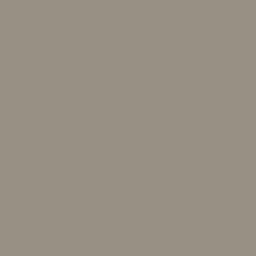

In [134]:
display(pil_img)